# Importing required libraryes

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

# Loading data

In [26]:
#loading data
file_1="Dataset/B0005_char_dataset.csv"
dataset=pd.read_csv(file_1)

# Corrections

In [27]:
#removing 170 th cycle it only has 5 rows in total
dataset=dataset.iloc[:541168]

#renaming columns for simplicity
dataset.columns=['cycle','voltage', 'current','temperature', 'Current', 'Voltage',"time"]

#removing discharge current rows/avoiding negative current
df=dataset[dataset["current"]>=0.02].reset_index(drop=True)

# converting time seconds->hour
df["time"]=df["time"]/3600

# Understanding

In [28]:
df["voltage"].describe()

count    506531.000000
mean          4.156229
std           0.098399
min           3.434644
25%           4.173178
50%           4.205399
75%           4.206028
max           4.313703
Name: voltage, dtype: float64

### voltage -Volt
### current -Amps
### Time    -hour

In [29]:
#max 2 Ah from dischrage dataset
C_max=2

# preprocessing
### Here we use columb counting method to make data frame

In [30]:
#calculate soc for each cycle
cycle_count=df["cycle"].unique()
soc_list=[]
# Update SOC for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df[df['cycle'] == cycle]
    
    cumulative_soc = [0.0]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i] - cycle_data['time'].iloc[i-1]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_soc.append(cumulative_soc[-1] +delta_charge)
        
    soc_list.extend(cumulative_soc)
    
soc = [(q / C_max) for q in soc_list]

df["Soc"]=soc
tp=['cycle','temperature', "Current", "Voltage","time","Soc"]
df=df[tp]

In [31]:
cor = df.corr()

<Axes: >

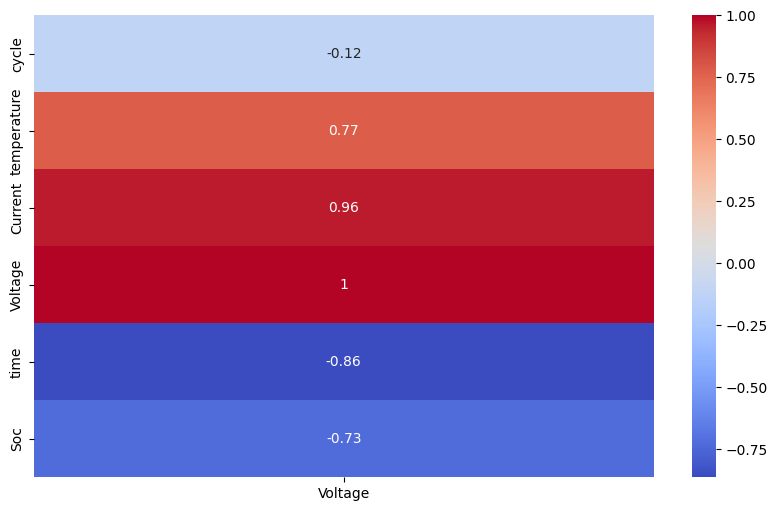

In [32]:
plt.figure(figsize=(10,6))  #select value out of range(0.05,-0.05)
sns.heatmap(cor[["Voltage"]],annot=True,cmap='coolwarm')

In [ ]:
#choosable parameters from the above graph Voltage,[time,current]

In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [ ]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y,)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
mi_scores = make_mi_scores(df[['cycle','voltage', 'current','temperature', 'current_charge',"time","Soc"]],df[["voltage_charge"]])

In [ ]:
mi_scores

In [ ]:
def plot_mi_scores(scores):
    plt.figure(dpi=200, figsize=(12, 5))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    for index, value in enumerate(scores):
        plt.text(value, index,str(round(value,3)))
plot_mi_scores(mi_scores)

In [ ]:
#voltage and time